In [ ]:
# Importing necessary libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [2]:
# To see all columns
pd.set_option('display.max_columns', None)

# Importing and Cleaning Data

In [3]:
# Importing data
pitches_22 = pd.read_csv('updated_pitches_22_1.csv')
pitches_23 = pd.read_csv('updated_pitches_23_1.csv')
pitches_24 = pd.read_csv('updated_pitches_24_1.csv')

# Combine them
pitches_total = pd.concat([pitches_22, pitches_23, pitches_24])

In [4]:
# Organizing rows by game, at bat
pitches_total_sorted = pitches_total.sort_values(['gameid', 'ab', 'pitchnum']).reset_index(drop=True)

In [5]:
# Filtering out position pitchers pitching
# If a pitcher ever hit as well, they are likely a position player
# Will also use some more filtering to ensure Ohtani is included
pitchers = pitches_total_sorted['pitcher'].unique()  # pitcher column contains MLBAM IDs
batters = pitches_total_sorted['batter'].unique()

# Edge case for Ohtani, any other known pitcher that somehow hit
pitch_counts = pitches_total_sorted['pitcher'].value_counts()
valid_pitchers = set(pitch_counts[pitch_counts > 200].index)

pitches_total_sorted = pitches_total_sorted[(~pitches_total_sorted['pitcher'].isin(batters)) |
                                            (pitches_total_sorted['pitcher'].isin(valid_pitchers))].reset_index(drop=True)


In [6]:
# Remove any Statcast errors in release speed (may need to filter out more errors)
pitches_total_sorted = (pitches_total_sorted[(pitches_total_sorted['relspeed'] > 50) &
                                             (pitches_total_sorted['relspeed'] < 108)]).reset_index(drop=True)

We want to work with grounded into double play batted ball profiles, so let's filter for plays where there was a 
grounded into double play

# Finding Most Optimal GIDP Contact -- MULTIPLE TYPES

In [7]:
dps = pitches_total_sorted[pitches_total_sorted['eventtype'] == 'grounded_into_double_play']
# We have ~10,000 instances of GIDP, so we can work with this

In [8]:
# 10,005 grounded into double plays instances
len(dps)

10005

<Axes: xlabel='ExitSpeed', ylabel='Density'>

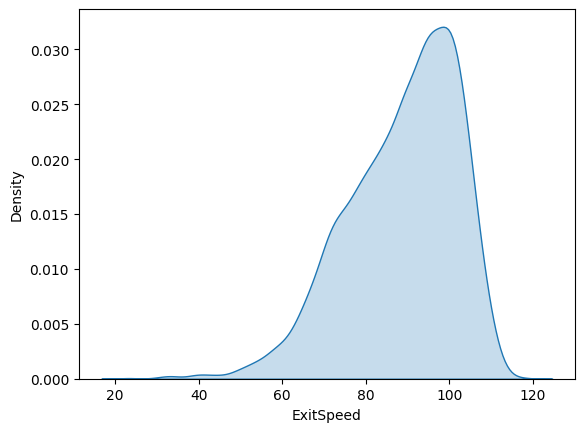

In [9]:
# GIDP batted ball profile distributions 
sns.kdeplot(dps['ExitSpeed'], fill=True)

In [10]:
np.mean(dps['ExitSpeed']), np.nanmedian(dps['ExitSpeed'])

(np.float64(88.63305389825408), np.float64(90.858215))

<Axes: xlabel='ExitSpeed', ylabel='Density'>

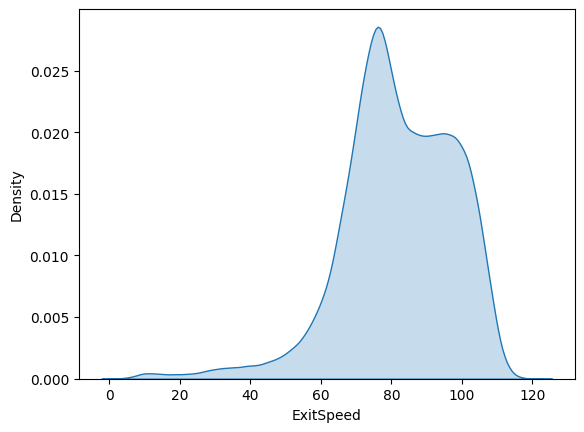

In [11]:
sns.kdeplot(pitches_total_sorted['ExitSpeed'], fill=True)

<Axes: xlabel='VExitAngle', ylabel='Density'>

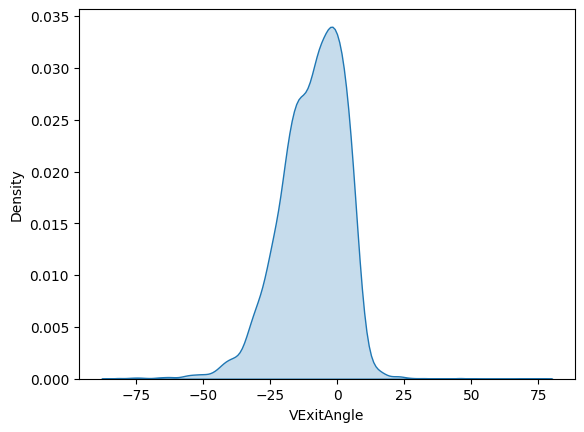

In [12]:
sns.kdeplot(dps['VExitAngle'], fill=True)

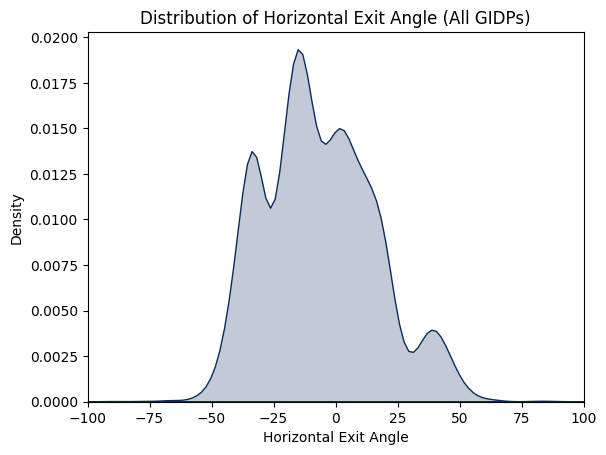

In [13]:
plt.figure()
sns.kdeplot(dps['HExitAngle'], fill=True, color="#092C5C")
plt.title("Distribution of Horizontal Exit Angle (All GIDPs)")
plt.xlabel("Horizontal Exit Angle")
plt.xlim(-100, 100)
plt.show()

<Axes: xlabel='HExitAngle', ylabel='Density'>

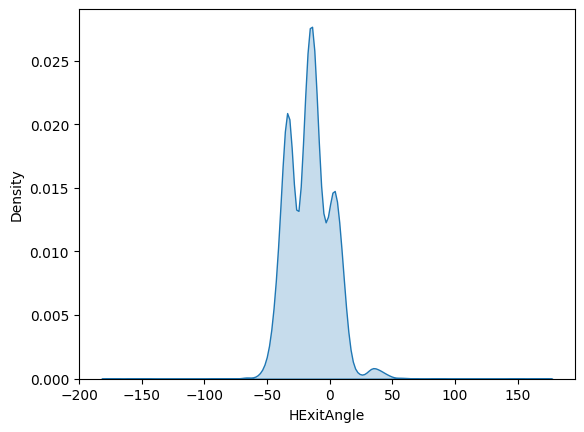

In [14]:
# Right handed hitters HExitAngle
sns.kdeplot(dps[dps['batterside'] == 'R']['HExitAngle'], fill=True)


<Axes: xlabel='HExitAngle', ylabel='Density'>

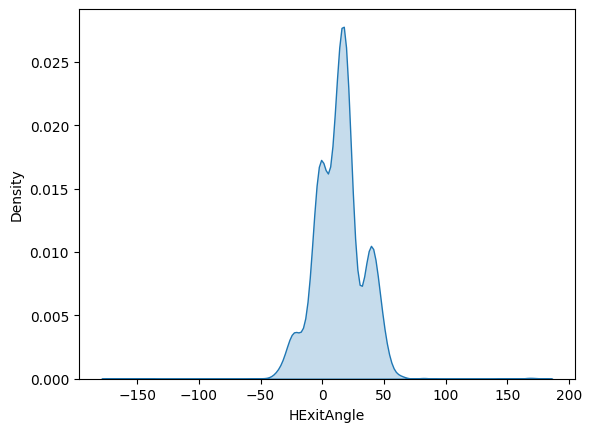

In [15]:
sns.kdeplot(dps[dps['batterside'] == 'L']['HExitAngle'], fill=True)

## Right-handed Hitters Optimal GIDP Contact

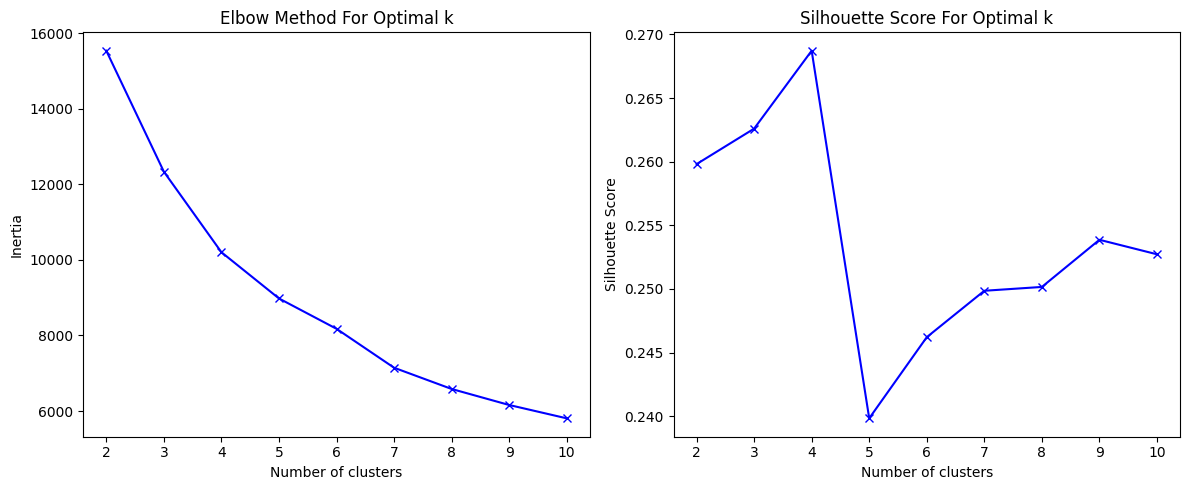

In [16]:
X_right = dps[dps['batterside'] == 'R'][['ExitSpeed', 'VExitAngle', 'HExitAngle']].dropna()

# Scale data
scaler_right = StandardScaler()
X_right_scaled = scaler_right.fit_transform(X_right)
# Determine optimal number of clusters using the elbow method and silhouette score
inertia = []
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_right_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_right_scaled, kmeans.labels_))

# Plotting the elbow method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')

# Plotting the silhouette scores
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.tight_layout()
plt.show()

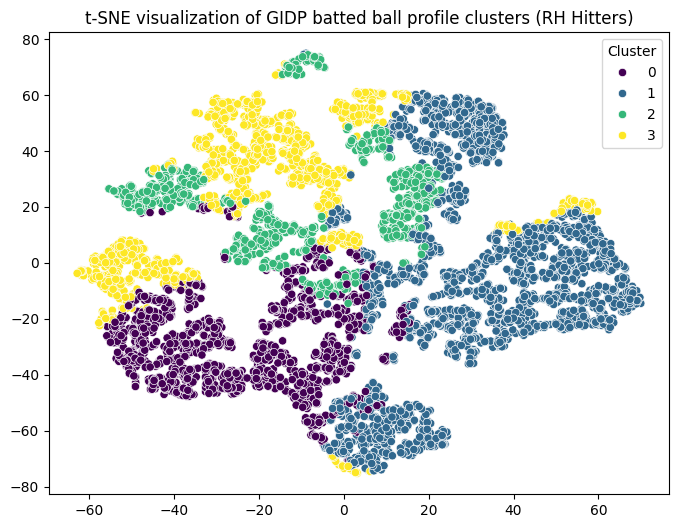

In [17]:
k = 4
kmeans_right = KMeans(n_clusters=k, n_init=50, random_state=42)
X_right['Cluster'] = kmeans_right.fit_predict(X_right_scaled)

tsne_right = TSNE(
    n_components=2, # 2D projection
    perplexity=40, # 30-50 is good here
    random_state=1236,
    n_jobs=-1
)

X_tsne_right = tsne_right.fit_transform(X_right_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne_right[:, 0], y=X_tsne_right[:, 1], hue=X_right['Cluster'], palette='viridis')
plt.title('t-SNE visualization of GIDP batted ball profile clusters (RH Hitters)')
plt.show()

## Left-handed Hitters Optimal GIDP Contact

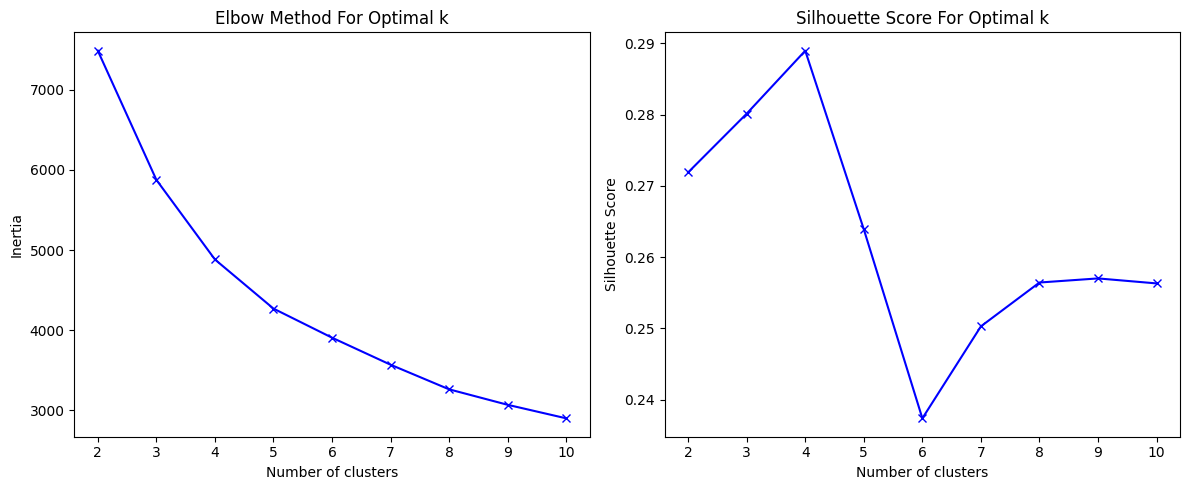

In [18]:
X_left = dps[dps['batterside'] == 'L'][['ExitSpeed', 'VExitAngle', 'HExitAngle']].dropna()
# Determine optimal number of clusters using the elbow method and silhouette score
# Scale data
scaler_left = StandardScaler()
X_left_scaled = scaler_left.fit_transform(X_left)
inertia = []
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_left_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_left_scaled, kmeans.labels_))

# Plotting the elbow method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
# Plotting the silhouette scores
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.tight_layout()
plt.show()

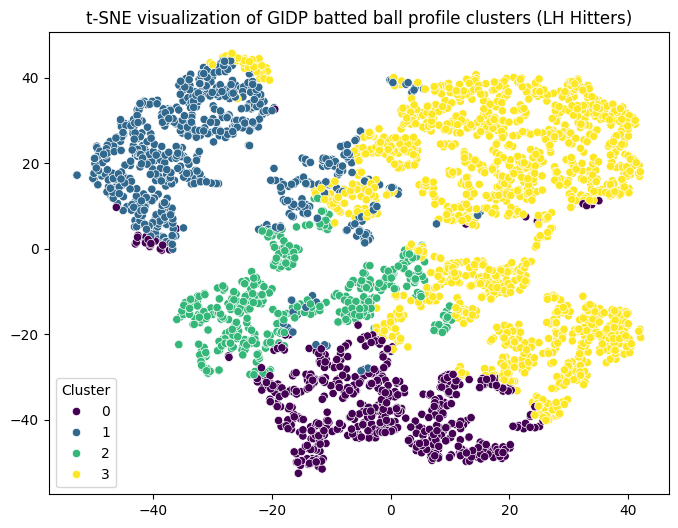

In [19]:
# K is 4
k = 4
kmeans_left = KMeans(n_clusters=k, n_init=50, random_state=42)
X_left['Cluster'] = kmeans_left.fit_predict(X_left_scaled)

tsne_left = TSNE(
    n_components=2, # 2D projection
    perplexity=40, # 30-50 is good here
    random_state=1236,
    n_jobs=-1
)

X_tsne_left = tsne_right.fit_transform(X_left_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne_left[:, 0], y=X_tsne_left[:, 1], hue=X_left['Cluster'], palette='viridis')
plt.title('t-SNE visualization of GIDP batted ball profile clusters (LH Hitters)')
plt.show()

## Exploring Each Cluster

In [20]:
# Right-handed clusters

RHH_cluster_0 = X_right[X_right['Cluster'] == 0]
RHH_cluster_1 = X_right[X_right['Cluster'] == 1]
RHH_cluster_2 = X_right[X_right['Cluster'] == 2]
RHH_cluster_3 = X_right[X_right['Cluster'] == 3]


# Left-handed clusters
LHH_cluster_0 = X_left[X_left['Cluster'] == 0]
LHH_cluster_1 = X_left[X_left['Cluster'] == 1]
LHH_cluster_2 = X_left[X_left['Cluster'] == 2]
LHH_cluster_3 = X_left[X_left['Cluster'] == 3]

# Cluster summaries for RHH
for i in range(4):
    cluster = X_right[X_right['Cluster'] == i]
    print(f"RHH Cluster {i}:")
    print(cluster.describe())
    print("\n")

for j in range(4):
    cluster = X_left[X_left['Cluster'] == j]
    print(f"LHH Cluster {j}:")
    print(cluster.describe())
    print("\n")

RHH Cluster 0:
         ExitSpeed   VExitAngle   HExitAngle  Cluster
count  1552.000000  1552.000000  1552.000000   1552.0
mean     86.121655   -18.881657   -33.721516      0.0
std      10.401094     9.088373    10.760939      0.0
min      44.046710   -82.071480  -173.132600      0.0
25%      79.617230   -24.128577   -39.849818      0.0
50%      87.402610   -17.829730   -34.298575      0.0
75%      93.405385   -12.593958   -26.808160      0.0
max     110.140400     1.745070   -13.458490      0.0


RHH Cluster 1:
         ExitSpeed   VExitAngle   HExitAngle  Cluster
count  2677.000000  2677.000000  2677.000000   2677.0
mean     99.365633    -4.850142   -14.181080      1.0
std       5.747214     7.011172    12.890473      0.0
min      85.199830   -26.713250   -42.847060      1.0
25%      95.161410    -9.686825   -21.125510      1.0
50%      99.600560    -4.070016   -14.615790      1.0
75%     103.482600     0.582191    -7.606992      1.0
max     118.319200     9.480888    33.365910      

### Visualizations of Clusters

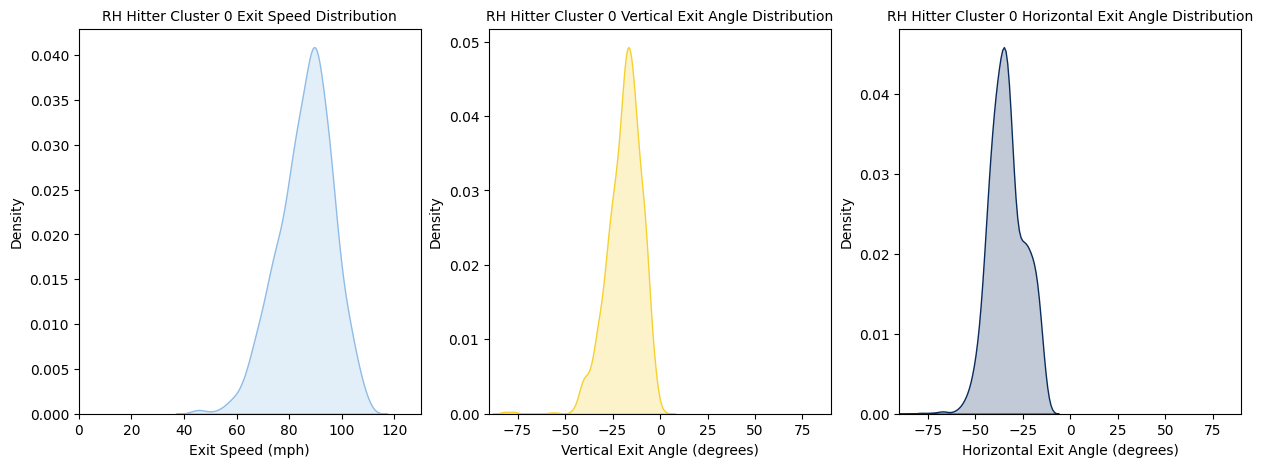

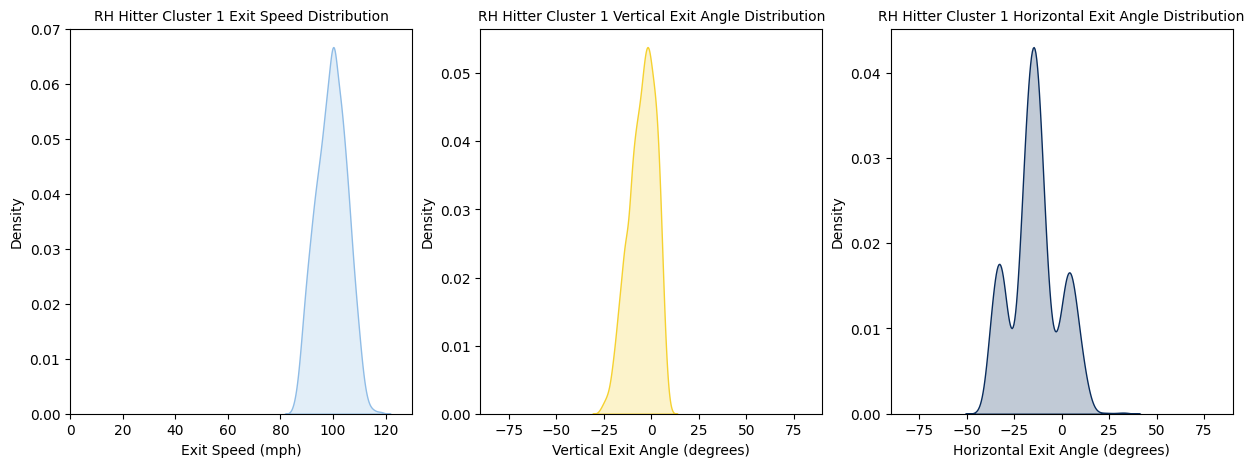

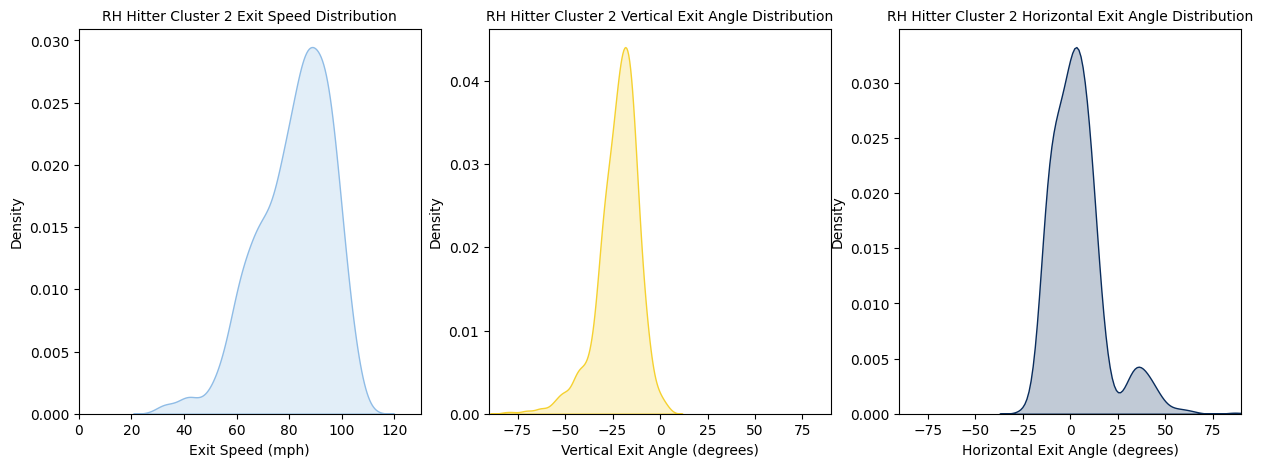

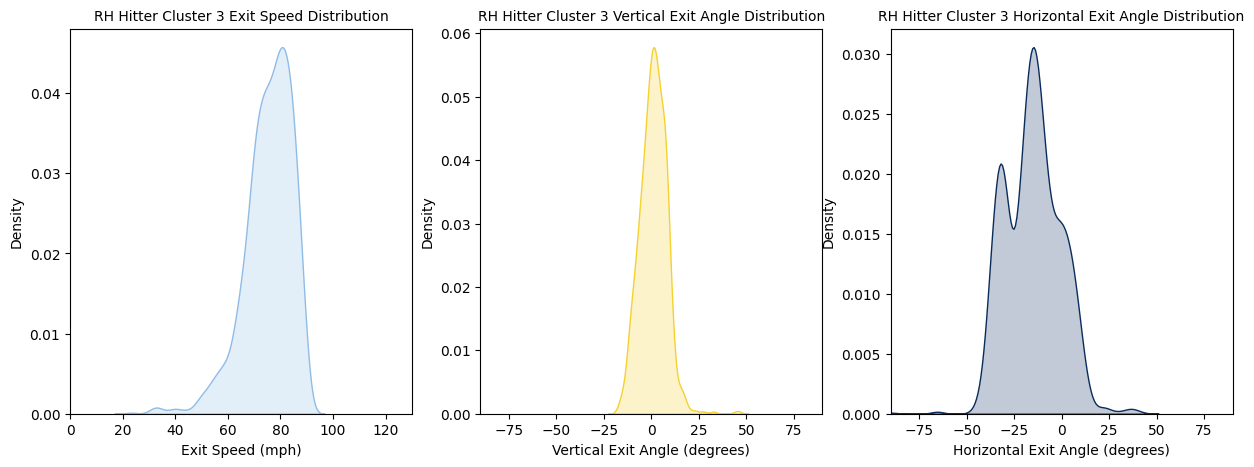

In [21]:
# Plotting densities for each cluster RHH

for i in range(4):
    cluster = X_right[X_right['Cluster'] == i]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3,  1)
    sns.kdeplot(cluster['ExitSpeed'], fill=True, color='#8FBCE6')
    plt.title(f'RH Hitter Cluster {i} Exit Speed Distribution', fontsize=10)
    plt.xlabel('Exit Speed (mph)')
    plt.xlim(0, 130)
    plt.subplot(1, 3, 2)
    sns.kdeplot(cluster['VExitAngle'], fill=True, color='#F5D130')
    plt.title(f'RH Hitter Cluster {i} Vertical Exit Angle Distribution', fontsize=10)
    plt.xlabel('Vertical Exit Angle (degrees)')
    plt.xlim(-90, 90)
    plt.subplot(1, 3, 3)
    sns.kdeplot(cluster['HExitAngle'], fill=True, color='#092C5C')
    plt.title(f'RH Hitter Cluster {i} Horizontal Exit Angle Distribution', fontsize=10)
    plt.xlabel('Horizontal Exit Angle (degrees)')
    plt.xlim(-90, 90)
    plt.show()

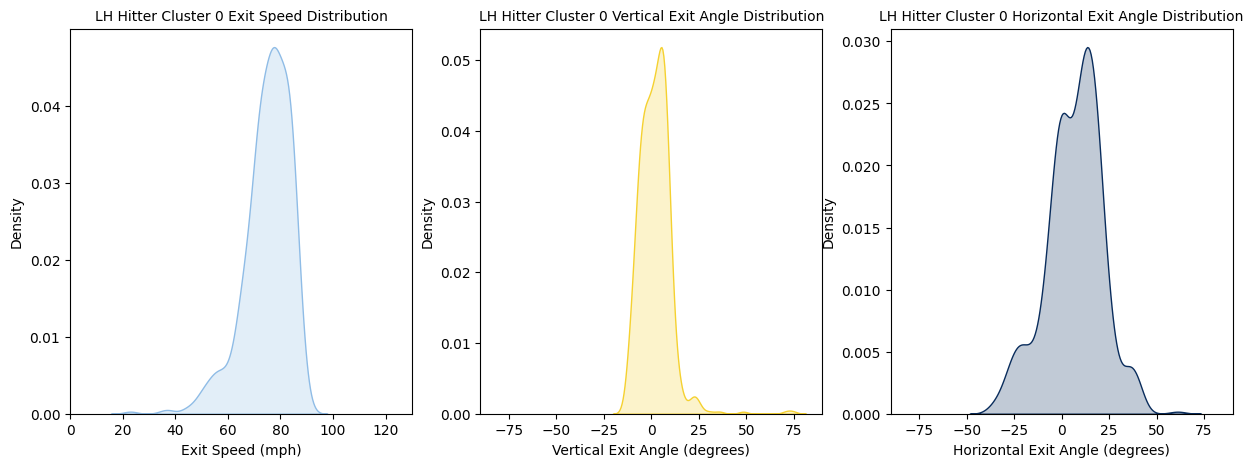

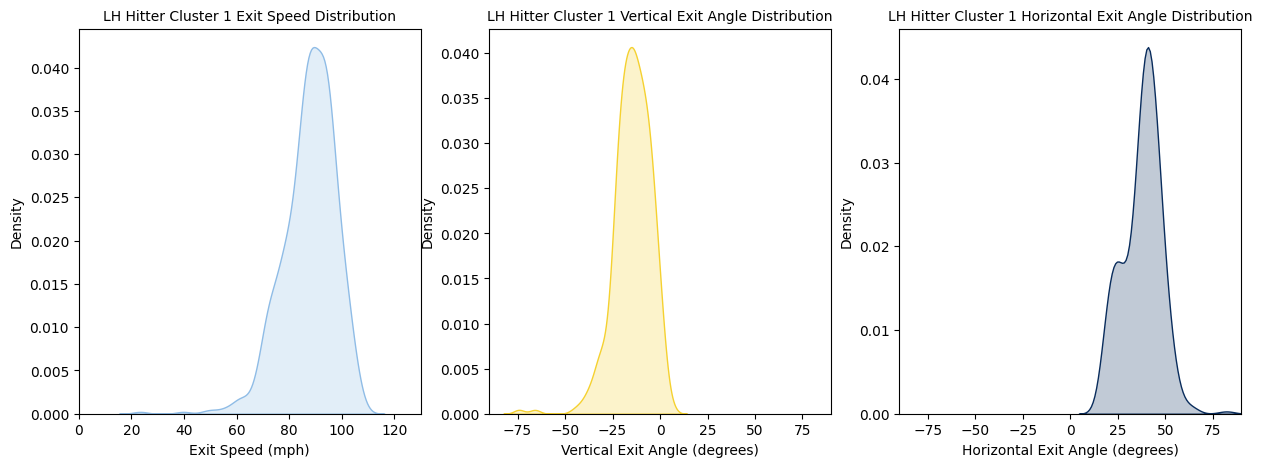

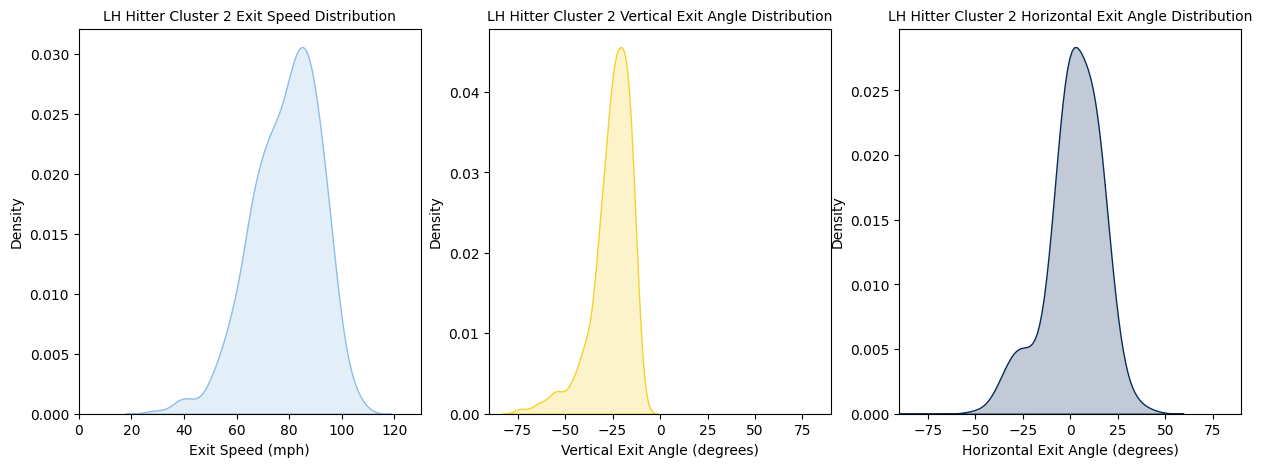

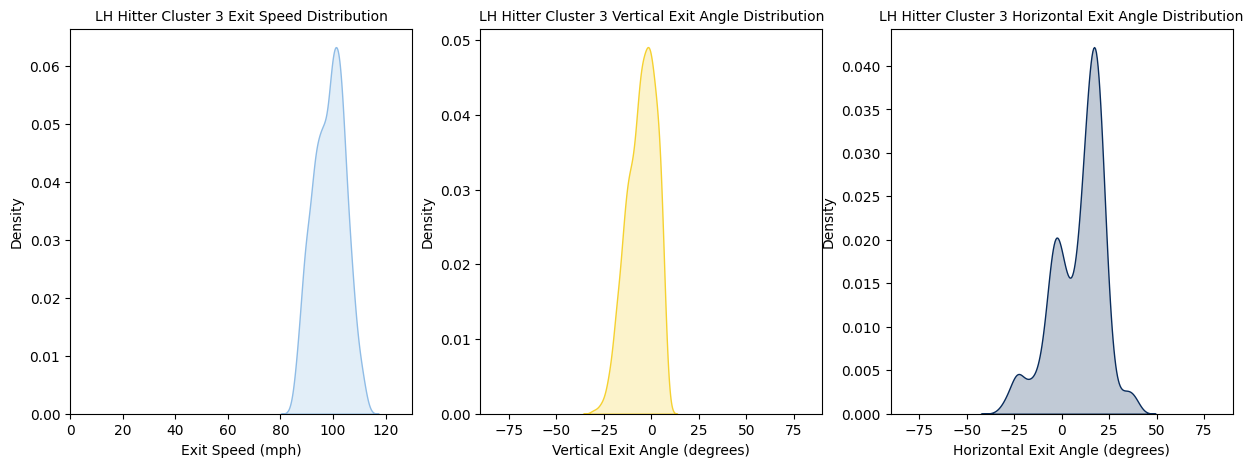

In [22]:
# Plotting densities for each cluster (LHH)

for j in range(4):
    cluster = X_left[X_left['Cluster'] == j]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    sns.kdeplot(cluster['ExitSpeed'], fill=True, color='#8FBCE6')
    plt.title(f'LH Hitter Cluster {j} Exit Speed Distribution', fontsize=10)
    plt.xlabel('Exit Speed (mph)')
    plt.xlim(0, 130)
    plt.subplot(1, 3, 2)
    sns.kdeplot(cluster['VExitAngle'], fill=True, color='#F5D130')
    plt.title(f'LH Hitter Cluster {j} Vertical Exit Angle Distribution', fontsize=10)
    plt.xlabel('Vertical Exit Angle (degrees)')
    plt.xlim(-90, 90)
    plt.subplot(1, 3, 3)
    sns.kdeplot(cluster['HExitAngle'], fill=True, color='#092C5C')
    plt.title(f'LH Hitter Cluster {j} Horizontal Exit Angle Distribution', fontsize=10)
    plt.xlabel('Horizontal Exit Angle (degrees)')
    plt.xlim(-90, 90)
    plt.show()

In [23]:
# Converting right, left handed dataframes to CSVs for export
X_right.to_csv('RHH_GIDP_ByCluster.csv', index=False)
X_left.to_csv('LHH_GIDP_ByCluster.csv', index=False)

In [25]:
# Cluster Centers for Right, Left
print("RHH Cluster Centers:")
print(scaler_right.inverse_transform(kmeans_right.cluster_centers_))
print("\nLHH Cluster Centers:")
print(scaler_left.inverse_transform(kmeans_left.cluster_centers_))

RHH Cluster Centers:
[[ 86.16527538 -18.82063588 -33.7145816 ]
 [ 99.37294918  -4.84541348 -14.13193427]
 [ 81.78293892 -22.23231858   4.08686438]
 [ 75.34863586   1.01234285 -15.18619346]]

LHH Cluster Centers:
[[ 74.93667019   1.94308248   6.66476166]
 [ 87.59216297 -14.60284926  38.37646882]
 [ 78.73517857 -25.5285728    0.99526452]
 [ 98.55103375  -5.14815172   8.99503865]]


## Given the Cluster Centers, Find Sweet Spot:

In [28]:
# Middle 80% of All 3 Variables as Sweet Spot for each GIDP Profile
# RIGHT HANDED
# Cluster 0
mid_50_right_0_ev = np.percentile(RHH_cluster_0['ExitSpeed'], [10, 90], axis=0)
mid_50_right_0_vla = np.percentile(RHH_cluster_0['VExitAngle'], [10, 90], axis=0)
mid_50_right_0_hla = np.percentile(RHH_cluster_0['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_right_0 = [mid_50_right_0_ev, mid_50_right_0_vla, mid_50_right_0_hla]
# Cluster 1
mid_50_right_1_ev = np.percentile(RHH_cluster_1['ExitSpeed'], [10, 90], axis=0)
mid_50_right_1_vla = np.percentile(RHH_cluster_1['VExitAngle'], [10, 90], axis=0)
mid_50_right_1_hla = np.percentile(RHH_cluster_1['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_right_1 = [mid_50_right_1_ev, mid_50_right_1_vla, mid_50_right_1_hla]
# Cluster 2
mid_50_right_2_ev = np.percentile(RHH_cluster_2['ExitSpeed'], [10, 90], axis=0)
mid_50_right_2_vla = np.percentile(RHH_cluster_2['VExitAngle'], [10, 90], axis=0)
mid_50_right_2_hla = np.percentile(RHH_cluster_2['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_right_2 = [mid_50_right_2_ev, mid_50_right_2_vla, mid_50_right_2_hla]
# Cluster 3
mid_50_right_3_ev = np.percentile(RHH_cluster_3['ExitSpeed'], [10, 90], axis=0)
mid_50_right_3_vla = np.percentile(RHH_cluster_3['VExitAngle'], [10, 90], axis=0)
mid_50_right_3_hla = np.percentile(RHH_cluster_3['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_right_3 = [mid_50_right_3_ev, mid_50_right_3_vla, mid_50_right_3_hla]

# LEFT HANDED
# Cluster 0
mid_50_left_0_ev = np.percentile(LHH_cluster_0['ExitSpeed'], [10, 90], axis=0)
mid_50_left_0_vla = np.percentile(LHH_cluster_0['VExitAngle'], [10, 90], axis=0)
mid_50_left_0_hla = np.percentile(LHH_cluster_0['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_left_0 = [mid_50_left_0_ev, mid_50_left_0_vla, mid_50_left_0_hla]
# Cluster 1
mid_50_left_1_ev = np.percentile(LHH_cluster_1['ExitSpeed'], [10, 90], axis=0)
mid_50_left_1_vla = np.percentile(LHH_cluster_1['VExitAngle'], [10, 90], axis=0)
mid_50_left_1_hla = np.percentile(LHH_cluster_1['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_left_1 = [mid_50_left_1_ev, mid_50_left_1_vla, mid_50_left_1_hla]
# Cluster 2
mid_50_left_2_ev = np.percentile(LHH_cluster_2['ExitSpeed'], [10, 90], axis=0)
mid_50_left_2_vla = np.percentile(LHH_cluster_2['VExitAngle'], [10, 90], axis=0)
mid_50_left_2_hla = np.percentile(LHH_cluster_2['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_left_2 = [mid_50_left_2_ev, mid_50_left_2_vla, mid_50_left_2_hla]
# Cluster 3
mid_50_left_3_ev = np.percentile(LHH_cluster_3['ExitSpeed'], [10, 90], axis=0)
mid_50_left_3_vla = np.percentile(LHH_cluster_3['VExitAngle'], [10, 90], axis=0)
mid_50_left_3_hla = np.percentile(LHH_cluster_3['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_left_3 = [mid_50_left_3_ev, mid_50_left_3_vla, mid_50_left_3_hla]

rhh_GIDP_sweet_spots = {
    'Cluster 0': sweet_spot_right_0,
    'Cluster 1': sweet_spot_right_1,
    'Cluster 2': sweet_spot_right_2,
    'Cluster 3': sweet_spot_right_3
}

lhh_GIDP_sweet_spots = {
    'Cluster 0': sweet_spot_left_0,
    'Cluster 1': sweet_spot_left_1,
    'Cluster 2': sweet_spot_left_2,
    'Cluster 3': sweet_spot_left_3

}

print("RHH GIDP Sweet Spots (10th to 90th Percentile Ranges):")
for cluster, ranges in rhh_GIDP_sweet_spots.items():
    print(f"{cluster}: Exit Speed {ranges[0]}, Vertical Launch Angle {ranges[1]}, Horizontal Launch Angle {ranges[2]}")
print("\nLHH GIDP Sweet Spots (10th to 90th Percentile Ranges):")
for cluster, ranges in lhh_GIDP_sweet_spots.items():
    print(f"{cluster}: Exit Speed {ranges[0]}, Vertical Launch Angle {ranges[1]}, Horizontal Launch Angle {ranges[2]}")

RHH GIDP Sweet Spots (10th to 90th Percentile Ranges):
Cluster 0: Exit Speed [71.826478 98.486125], Vertical Launch Angle [-30.646302   -8.1809735], Horizontal Launch Angle [-44.439125 -20.10135 ]
Cluster 1: Exit Speed [ 91.503252 106.80714 ], Vertical Launch Angle [-14.640746    3.7866784], Horizontal Launch Angle [-32.734876    4.7644908]
Cluster 2: Exit Speed [62.477488 97.839976], Vertical Launch Angle [-35.043813 -10.72497 ], Horizontal Launch Angle [-11.608352  17.402104]
Cluster 3: Exit Speed [64.135324 85.613944], Vertical Launch Angle [-8.1400314  8.8388861], Horizontal Launch Angle [-33.968526    3.8510228]

LHH GIDP Sweet Spots (10th to 90th Percentile Ranges):
Cluster 0: Exit Speed [64.363912 84.463644], Vertical Launch Angle [-7.4345796  9.7012342], Horizontal Launch Angle [-12.381022  22.618822]
Cluster 1: Exit Speed [74.236672 99.226006], Vertical Launch Angle [-25.482006   -3.1901688], Horizontal Launch Angle [22.672844 49.00901 ]
Cluster 2: Exit Speed [62.2861   94.189

# Feature Engineering Sweet-Spots on the entire dataset

We are just going to create a binary classifier problem (at least for now). 

We can always create a multi-class problem to determine whicn types of GIDP each pitch type induces the most.

In [29]:
# First, filter the main dataset to just balls put into play
bip_df = pitches_total_sorted[pitches_total_sorted['pitchresult_desc'].isin(
    ['Hit Into Play - Out(s)', 'Hit Into Play - Run(s)', 'Hit Into Play - No Out(s)'])
 ].copy()

In [30]:
# Apply a function to determine if each batted ball falls within any of the sweet spots

def is_in_sweet_spot(row, sweet_spots_right=rhh_GIDP_sweet_spots, 
                     sweet_spots_left=lhh_GIDP_sweet_spots, **kwargs):
    '''
    Determines if a batted ball falls within any of the defined sweet spots
    for right-handed or left-handed hitters based on exit velocity, vertical launch angle,
    and horizontal launch angle. This essentially captures whether a batted ball
    has the characteristics of a typical GIDP batted ball profile (many types).

    Params:
    row: A row from the DataFrame
    Returns:
    bool: True if the batted ball falls within any sweet spot, False otherwise
    '''
    ev = row['ExitSpeed']
    vla = row['VExitAngle']
    hla = row['HExitAngle']
    if row['batterside'] == 'R':

        for cluster, ranges in sweet_spots_right.items():
            if (ranges[0][0] <= ev <= ranges[0][1] and
                ranges[1][0] <= vla <= ranges[1][1] and
                ranges[2][0] <= hla <= ranges[2][1]):
                return 1
            
    elif row['batterside'] == 'L':
        for cluster, ranges in sweet_spots_left.items():
            if (ranges[0][0] <= ev <= ranges[0][1] and
                ranges[1][0] <= vla <= ranges[1][1] and
                ranges[2][0] <= hla <= ranges[2][1]):
                return 1
    return 0



In [31]:
# Apply the function to create a new column 'GIDP_SweetSpot'
bip_df['GIDP_SweetSpot'] = bip_df.apply(is_in_sweet_spot, axis=1)

In [32]:
print(bip_df[["ExitSpeed", "VExitAngle", "HExitAngle", "batterside"]].head())


    ExitSpeed  VExitAngle  HExitAngle batterside
10   55.31276  -42.227200   -0.448136          R
19   91.72955   -0.069351   12.199050          R
21  100.97140   36.611920  -17.393650          R
31   98.19635    8.123025   -3.759704          R
34   69.13850   64.647930   -1.996992          L


Now that we have GIDP clusters, find sweet spots for each metric. But they are all dependent of eachother, so need to figure this out.

In [33]:
# Saving clusters to CSV
X_right.to_csv('RHH_GIDP_Clusters.csv', index=False)
X_left.to_csv('LHH_GIDP_Clusters.csv', index=False)

In [34]:
# Drop NA values for modeling
bip_df = bip_df.dropna()

In [35]:
# Create four different subsets based on pitcher-batter handedness
RHP_RHH = bip_df[(bip_df['pitcherthrows'] == 'R') & (bip_df['batterside'] == 'R')]
RHP_LHH = bip_df[(bip_df['pitcherthrows'] == 'R') & (bip_df['batterside'] == 'L')]
LHP_RHH = bip_df[(bip_df['pitcherthrows'] == 'L') & (bip_df['batterside'] ==  'R')]
LHP_LHH = bip_df[(bip_df['pitcherthrows'] == 'L') & (bip_df['batterside'] == 'L')]

In [36]:
# Export to csvs
RHP_RHH.to_csv('RHP_RHH_BIP.csv', index=False)
RHP_LHH.to_csv('RHP_LHH_BIP.csv', index=False)
LHP_RHH.to_csv('LHP_RHH_BIP.csv', index=False)
LHP_LHH.to_csv('LHP_LHH_BIP.csv', index=False)

# Engineering Our Own Pitch Types

## Split by Handedness

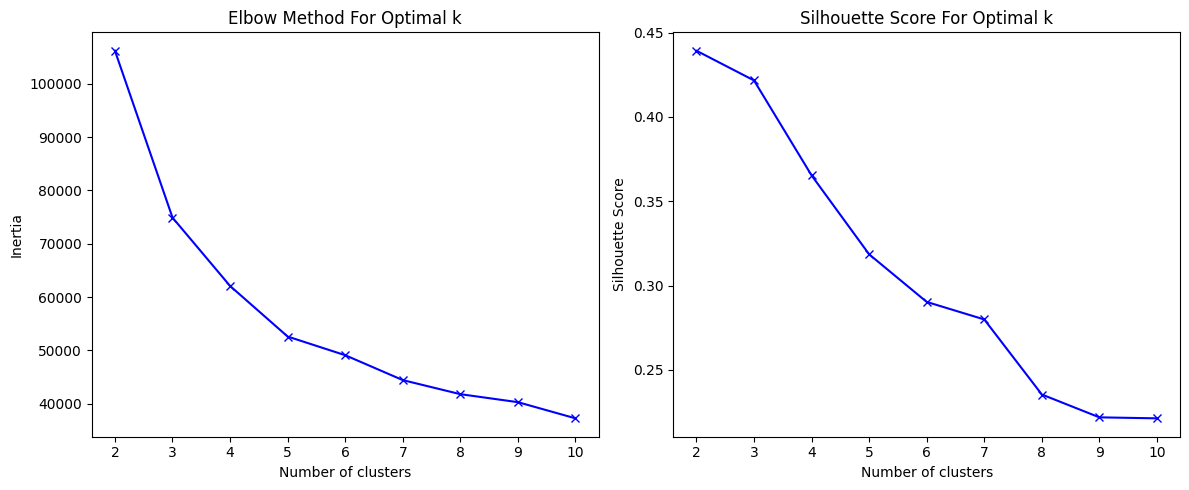

In [ ]:
# Right Handed pitches
RHP_pitch_profiles = (pitches_total_sorted[pitches_total_sorted['pitcherthrows'] == 'R']
                      [['spinrate', 'relspeed', 'inducedvertbreak', 
                        'horzbreak']].dropna())
random_50k_idx = random.sample(range(len(RHP_pitch_profiles)), 50000)
RHP_pitch_profiles = RHP_pitch_profiles.iloc[random_50k_idx]
# Scale data
RHP_scaler = StandardScaler()
RHP_pitch_profiles_scaled = RHP_scaler.fit_transform(RHP_pitch_profiles)
# KMeans clustering

# Use elbow method and silhouette score to find optimal k
inertia = []
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(RHP_pitch_profiles_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(RHP_pitch_profiles_scaled, kmeans.labels_))
# Plotting the elbow method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
# Plotting the silhouette scores
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.tight_layout()
plt.show()

In [38]:
# Running kmeans: 
k = 5
kmeans_RHP = KMeans(n_clusters=k, n_init=50, random_state=42)
RHP_pitch_profiles['Cluster'] = kmeans_RHP.fit_predict(RHP_pitch_profiles_scaled)

In [39]:
# Cluster centers for RHP
print("RHP Cluster Centers:")
print(RHP_scaler.inverse_transform(kmeans_RHP.cluster_centers_))

RHP Cluster Centers:
[[1522.27353898   85.73958267    4.17277053   11.81607243]
 [2403.12449576   86.90792097    4.01250733   -4.08631396]
 [2129.81897799   92.42832096    7.3355579    15.0837136 ]
 [2595.39198569   80.92928605   -5.90914374  -11.22046308]
 [2318.46281182   94.61697577   15.95688309    7.05143275]]


In [ ]:
# Apply clusters to our datasets
RHP_RHH['Cluster'] = kmeans_RHP.predict(RHP_scaler.transform(
    RHP_RHH[['spinrate', 'relspeed', 'inducedvertbreak', 'horzbreak']]
    ))

RHP_LHH['Cluster'] = kmeans_RHP.predict(RHP_scaler.transform(
    RHP_LHH[['spinrate', 'relspeed', 'inducedvertbreak', 'horzbreak']]
    ))

/var/folders/zd/lzk6p4jx3j760xhr1rwpzsnm0000gn/T/ipykernel_78609/2846908076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RHP_RHH['Cluster'] = kmeans_RHP.predict(RHP_scaler.transform(
/var/folders/zd/lzk6p4jx3j760xhr1rwpzsnm0000gn/T/ipykernel_78609/2846908076.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RHP_LHH['Cluster'] = kmeans_RHP.predict(RHP_scaler.transform(


## Left Handed Now

In [42]:
# Left handed pitches
LHP_pitch_profiles = (pitches_total_sorted[pitches_total_sorted['pitcherthrows'] == 'L']
                      [['spinrate', 'relspeed', 'inducedvertbreak', 
                        'horzbreak']].dropna())
random_50k_idx = random.sample(range(len(LHP_pitch_profiles)), 50000)
LHP_pitch_profiles = LHP_pitch_profiles.iloc[random_50k_idx]
# Scale data
LHP_scaler = StandardScaler()
LHP_pitch_profiles_scaled = LHP_scaler.fit_transform(LHP_pitch_profiles)
# KMeans clustering
k = 5
kmeans_LHP = KMeans(n_clusters=k, n_init=50, random_state=42)
LHP_pitch_profiles['Cluster'] = kmeans_LHP.fit_predict(LHP_pitch_profiles_scaled)
# Cluster centers for LHP
print("LHP Cluster Centers:")
print(LHP_scaler.inverse_transform(kmeans_LHP.cluster_centers_))

LHP Cluster Centers:
[[2107.03360809   91.41769261    8.08332912  -15.36911953]
 [2504.901688     79.20451242   -5.70587908   10.8365228 ]
 [2267.25998774   93.38007987   16.17498871   -7.39765887]
 [1622.45618488   83.82576513    5.92101051  -13.17182294]
 [2304.46461546   85.43279423    3.83627532    3.43016761]]


In [43]:
# Apply to our subsets
LHP_RHH['Cluster'] = kmeans_LHP.predict(LHP_scaler.transform(
    LHP_RHH[['spinrate', 'relspeed', 'inducedvertbreak', 'horzbreak']]
    ))
LHP_LHH['Cluster'] = kmeans_LHP.predict(LHP_scaler.transform(
    LHP_LHH[['spinrate', 'relspeed', 'inducedvertbreak', 'horzbreak']]
    ))

/var/folders/zd/lzk6p4jx3j760xhr1rwpzsnm0000gn/T/ipykernel_78609/3302102370.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LHP_RHH['Cluster'] = kmeans_LHP.predict(LHP_scaler.transform(
/var/folders/zd/lzk6p4jx3j760xhr1rwpzsnm0000gn/T/ipykernel_78609/3302102370.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LHP_LHH['Cluster'] = kmeans_LHP.predict(LHP_scaler.transform(


In [45]:
# Investigating specific pitch clusters
for i in range(5):
    cluster = RHP_pitch_profiles[RHP_pitch_profiles['Cluster'] == i]
    print(f"RHP Cluster {i}:")
    print(cluster.describe())
    print("\n")
for j in range(5):
    cluster = LHP_pitch_profiles[LHP_pitch_profiles['Cluster'] == j]
    print(f"LHP Cluster {j}:")
    print(cluster.describe())
    print("\n")

RHP Cluster 0:
          spinrate     relspeed  inducedvertbreak    horzbreak  Cluster
count  4775.000000  4775.000000       4775.000000  4775.000000   4775.0
mean   1522.909297    85.740114          4.174549    11.813645      0.0
std     312.013346     3.253834          5.060654     4.847346      0.0
min       7.448266    62.852340        -16.075260   -19.316810      0.0
25%    1381.002500    83.733100          1.095908     9.656582      0.0
50%    1573.782000    85.919040          4.196805    12.808520      0.0
75%    1733.480000    87.935040          7.522298    15.041835      0.0
max    2248.444000    97.747580         21.524170    27.255580      0.0


RHP Cluster 1:
           spinrate      relspeed  inducedvertbreak     horzbreak  Cluster
count  11083.000000  11083.000000      11083.000000  11083.000000  11083.0
mean    2403.170777     86.908857          4.014115     -4.089419      1.0
std      211.000675      2.968924          4.281007      3.940718      0.0
min     1649.730000 

In [60]:
# See what pitch types are associated with each cluster
for i in range(5):
    print(f"RHP Cluster {i} Pitch Types:")
    print(RHP_RHH[RHP_RHH['Cluster'] == i]['pitchname_desc'].value_counts())
    print("\n")

RHP Cluster 0 Pitch Types:
pitchname_desc
Sinker          29196
Four-seam FB     2771
Changeup         2056
Splitter          199
Slider            109
Cutter             73
Two-seam FB         3
Screwball           1
Name: count, dtype: int64


RHP Cluster 1 Pitch Types:
pitchname_desc
Slider           25077
Cutter            9364
Sweeper           1726
Curveball          711
Four-seam FB       327
Changeup           319
Knuckle Curve      282
Sinker             105
Splitter            30
Slurve              27
Screwball            8
Forkball             2
Slow Curve           1
Name: count, dtype: int64


RHP Cluster 2 Pitch Types:
pitchname_desc
Slider           8754
Curveball        6758
Sweeper          4629
Knuckle Curve    1689
Slurve            323
Cutter            132
Sinker             48
Four-seam FB       42
Changeup           10
Slow Curve          5
Splitter            1
Screwball           1
Name: count, dtype: int64


RHP Cluster 3 Pitch Types:
pitchname_desc
Four-seam

In [46]:
# See what pitch types are associated with each cluster 

for i in range(5):
    print(f"LHP Cluster {i} Pitch Types:")
    print(LHP_LHH[LHP_LHH['Cluster'] == i]['pitchname_desc'].value_counts())
    print("\n")


LHP Cluster 0 Pitch Types:
pitchname_desc
Sinker          6051
Four-seam FB    1028
Changeup         203
Cutter            27
Slider             5
Splitter           1
Name: count, dtype: int64


LHP Cluster 1 Pitch Types:
pitchname_desc
Slider           1674
Curveball        1453
Sweeper           808
Knuckle Curve     173
Slurve             85
Cutter             61
Name: count, dtype: int64


LHP Cluster 2 Pitch Types:
pitchname_desc
Four-seam FB    6154
Sinker           770
Cutter           124
Slider            35
Changeup           8
Name: count, dtype: int64


LHP Cluster 3 Pitch Types:
pitchname_desc
Changeup         650
Sinker           183
Slider            50
Splitter          43
Four-seam FB      30
Cutter            16
Knuckle Curve     14
Curveball          8
Sweeper            4
Name: count, dtype: int64


LHP Cluster 4 Pitch Types:
pitchname_desc
Slider           4294
Cutter           1506
Sweeper           312
Curveball         296
Four-seam FB      157
Knuckle Curve   

In [47]:
# Converting to CSVs for export to R
RHP_RHH.to_csv('RHP_RHH_GIDP_ByPitchCluster.csv', index=False)
RHP_LHH.to_csv('RHP_LHH_GIDP_ByPitchCluster.csv', index=False)
LHP_RHH.to_csv('LHP_RHH_GIDP_ByPitchCluster.csv', index=False)
LHP_LHH.to_csv('LHP_LHH_GIDP_ByPitchCluster.csv', index=False)